<a href="https://www.kaggle.com/code/okayananya/titanic-classifier-bi?scriptVersionId=157680951" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import tensorflow_decision_forests as tfdf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# **Importing Data**

In [3]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
test_df.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# **Exploratory Data Analysis**

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

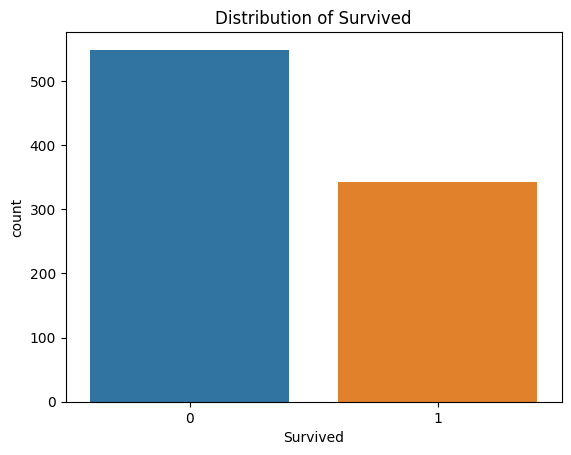

In [10]:
# Analyze the distribution of the target variable 'Survived'
sns.countplot(x ='Survived', data = train_df)
plt.title('Distribution of Survived')
plt.show()

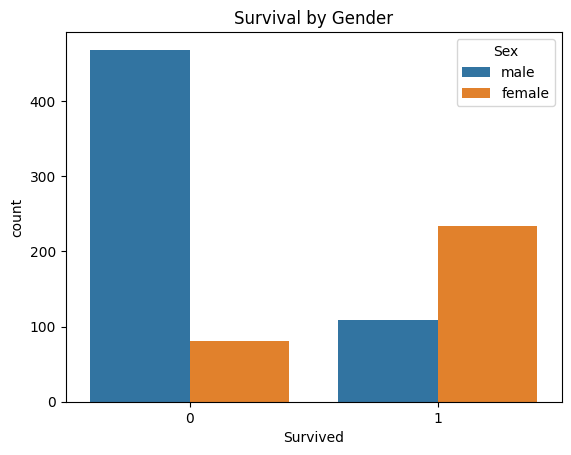

In [11]:
# Explore relationships between different features and the target variable
sns.countplot(x='Survived', hue='Sex', data=train_df)
plt.title('Survival by Gender')
plt.show()

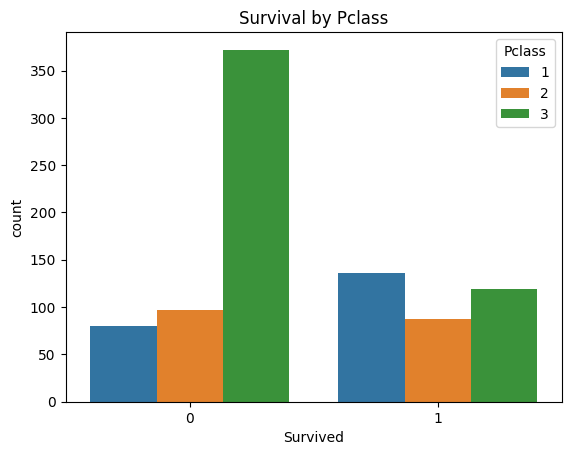

In [12]:
sns.countplot(x='Survived', hue='Pclass', data=train_df)
plt.title('Survival by Pclass')
plt.show()

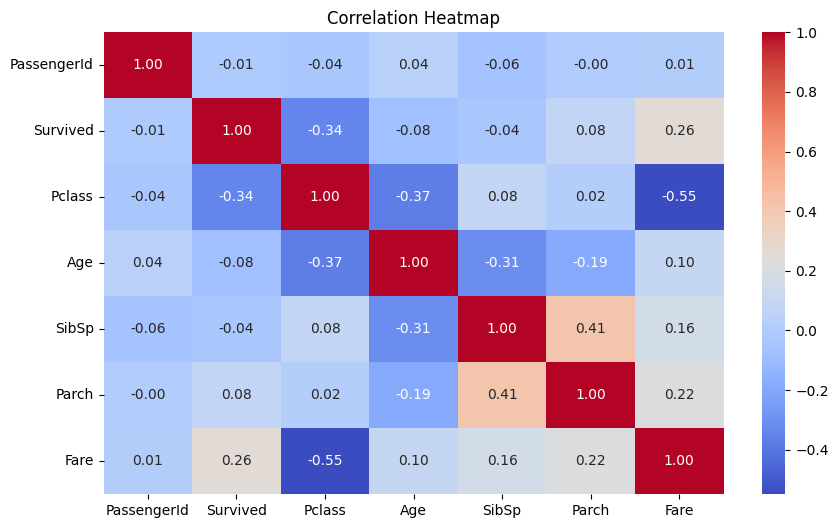

In [13]:
# Exclude non-numeric columns (e.g., 'Name') for correlation heatmap
numeric_columns = train_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = train_df[numeric_columns].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# **Cleaning Train Data**

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [15]:
null_values = train_df.isnull()
null_sum = null_values.sum()
print("Number of null values per variable:\n", null_sum)

Number of null values per variable:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [16]:
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)

In [17]:
# Convert categorical variables into numerical representations
train_df = pd.get_dummies(train_df, columns=['Sex', 'Embarked'], drop_first=True)

In [18]:
# Feature engineering (A new feature 'FamilySize' by combining 'SibSp' and 'Parch')
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1

In [19]:
# Drop unnecessary columns
train_df = train_df.drop(['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis=1)

**Feature Selection**

In [20]:
selected_features = ['PassengerId','Pclass', 'Age', 'Fare', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'FamilySize']

In [21]:
target = 'Survived'

In [22]:
X = train_df[selected_features]
y = train_df[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
from sklearn.impute import SimpleImputer

# Handle Missing Values in Training Data
imputer = SimpleImputer(strategy='median')  # You can choose a different strategy based on your needs
X_train_imputed = imputer.fit_transform(X_train)

# **Random Forest Classifier**

In [24]:
model = RandomForestClassifier()

model.fit(X_train_imputed, y_train)

RandomForestClassifier()

In [25]:
predictions = model.predict(X_val)
accuracy = accuracy_score(y_val, predictions)
print(f'Accuracy on validation set: {accuracy}')

Accuracy on validation set: 0.8212290502793296


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


# **Preparing Test Data**

In [26]:
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)

In [27]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [28]:
# Convert Categorical Variables in Test Data
test_df = pd.get_dummies(test_df, columns=['Sex', 'Embarked'], drop_first=True)

In [29]:
# Feature Engineering (A new feature 'FamilySize' by combining 'SibSp' and 'Parch')
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

In [30]:
test_df = test_df.drop(['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis=1)

In [31]:
X_test = test_df[selected_features]

**Predictions RF**

In [32]:
test_predictions = model.predict(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [33]:
submission_df = pd.DataFrame({'PassengerId': X_test['PassengerId'], 'Survived': test_predictions})
submission_df.to_csv('submission.csv', index=False)

*The submission score was 0.76555 with feature selection and random forest classifier*

****

# **Support Vector Machine (SVM) classifier**

In [34]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create and train the SVM model
svm_model = SVC()
svm_model.fit(X_train_imputed, y_train)

SVC()

In [35]:
# Make predictions on the validation set
predictions_val_svm = svm_model.predict(X_val)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [36]:
# Evaluate accuracy on the validation set
accuracy_val_svm = accuracy_score(y_val, predictions_val_svm)

print(f'Accuracy on the validation set using SVM: {accuracy_val_svm}')

Accuracy on the validation set using SVM: 0.5977653631284916


In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Step 1: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [38]:
# Step 2: Hyperparameter Tuning
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf', 'poly']}
svm_model_tuned = SVC()
grid_search = GridSearchCV(svm_model_tuned, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Evaluate the model with the best parameters on the validation set
best_svm_model = grid_search.best_estimator_
predictions_val_tuned = best_svm_model.predict(X_val_scaled)
accuracy_val_tuned = accuracy_score(y_val, predictions_val_tuned)
print(f'Accuracy on the validation set using tuned SVM: {accuracy_val_tuned}')


Best Hyperparameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy on the validation set using tuned SVM: 0.8100558659217877


**Predictions SVM**

In [39]:
# Scale the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Make predictions on the test set
predictions_svm_test = best_svm_model.predict(X_test_scaled)

# Create a submission DataFrame
submission_svm_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': predictions_svm_test})

# Save the submission to a CSV file
submission_svm_df.to_csv('submission_svm.csv', index=False)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


*The submission score was 0.77990 with feature scaling, hyperparameter tuning and SVM*

****

# **Logistic Regression**

In [40]:
from sklearn.linear_model import LogisticRegression

# Create and train the Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train_scaled, y_train)

# Make predictions on the validation set
predictions_val_logistic = logistic_model.predict(X_val_scaled)

# Evaluate accuracy on the validation set
accuracy_val_logistic = accuracy_score(y_val, predictions_val_logistic)
print(f'Accuracy on the validation set using Logistic Regression: {accuracy_val_logistic}')

Accuracy on the validation set using Logistic Regression: 0.8100558659217877


**Predictions LR**

In [41]:
# Make predictions on the test set
predictions_lr_test = logistic_model.predict(X_test_scaled)

# Create a submission DataFrame
submission_lr_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': predictions_lr_test})

# Save the submission to a CSV file
submission_lr_df.to_csv('submission_lr.csv', index=False)

*The submission score was 0.75358 with feature scaling, hyperparameter tuning and Logistic Regression*

****

# **Gradient Boosting Classifier**

In [42]:
from sklearn.ensemble import GradientBoostingClassifier

# Create and train the Gradient Boosting model
gradient_boosting_model = GradientBoostingClassifier()
gradient_boosting_model.fit(X_train_scaled, y_train)

# Make predictions on the validation set
predictions_val_gb = gradient_boosting_model.predict(X_val_scaled)

# Evaluate accuracy on the validation set
accuracy_val_gb = accuracy_score(y_val, predictions_val_gb)
print(f'Accuracy on the validation set using Gradient Boosting: {accuracy_val_gb}')

Accuracy on the validation set using Gradient Boosting: 0.8212290502793296


**Predictions GB**

In [43]:
# Make predictions on the test set
predictions_gb_test = gradient_boosting_model.predict(X_test_scaled)

# Create a submission DataFrame
submission_gb_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': predictions_gb_test})

# Save the submission to a CSV file
submission_gb_df.to_csv('submission_gb.csv', index=False)

*The submission score was 0.79425 with feature scaling and Gradient Boosting Classifier*

**Hyperparameters**

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid for Gradient Boosting
param_grid_gb = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}

# Create and train the Gradient Boosting model with hyperparameter tuning
gb_model_tuned = GradientBoostingClassifier()
grid_search_gb = GridSearchCV(gb_model_tuned, param_grid_gb, cv=5, scoring='accuracy')
grid_search_gb.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params_gb = grid_search_gb.best_params_
print(f'Best Hyperparameters for Gradient Boosting: {best_params_gb}')

# Evaluate the model with the best parameters on the validation set
best_gb_model = grid_search_gb.best_estimator_
predictions_val_gb_tuned = best_gb_model.predict(X_val_scaled)
accuracy_val_gb_tuned = accuracy_score(y_val, predictions_val_gb_tuned)
print(f'Accuracy on the validation set using tuned Gradient Boosting: {accuracy_val_gb_tuned}')

Best Hyperparameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Accuracy on the validation set using tuned Gradient Boosting: 0.8212290502793296


****

# **K-Nearest Neighbors**

In [45]:
from sklearn.neighbors import KNeighborsClassifier

# Create and train the KNN model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)

# Make predictions on the validation set
predictions_val_knn = knn_model.predict(X_val_scaled)

# Evaluate accuracy on the validation set
accuracy_val_knn = accuracy_score(y_val, predictions_val_knn)
print(f'Accuracy on the validation set using K-Nearest Neighbors: {accuracy_val_knn}')

Accuracy on the validation set using K-Nearest Neighbors: 0.8100558659217877


In [46]:
# Make predictions on the test set
predictions_knn_test = knn_model.predict(X_test_scaled)

# Create a submission DataFrame
submission_knn_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': predictions_knn_test})

# Save the submission to a CSV file
submission_knn_df.to_csv('submission_knn.csv', index=False)

*The submission score was 0.79186 with feature scaling and K Neighbors Classifier*

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid for KNN
param_grid_knn = {'n_neighbors': [3, 5, 7, 10]}

# Create and train the KNN model with hyperparameter tuning
knn_model_tuned = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn_model_tuned, param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params_knn = grid_search_knn.best_params_
print(f'Best Hyperparameters for KNN: {best_params_knn}')

# Evaluate the model with the best parameters on the validation set
best_knn_model = grid_search_knn.best_estimator_
predictions_val_knn_tuned = best_knn_model.predict(X_val_scaled)
accuracy_val_knn_tuned = accuracy_score(y_val, predictions_val_knn_tuned)
print(f'Accuracy on the validation set using tuned KNN: {accuracy_val_knn_tuned}')

Best Hyperparameters for KNN: {'n_neighbors': 10}
Accuracy on the validation set using tuned KNN: 0.8100558659217877


# **Random Forest with Feature Scaling**

In [48]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the validation set
predictions_val_rf = rf_model.predict(X_val_scaled)

# Evaluate accuracy on the validation set
accuracy_val_rf = accuracy_score(y_val, predictions_val_rf)
print(f'Accuracy on the validation set using Random Forest: {accuracy_val_rf}')

Accuracy on the validation set using Random Forest: 0.8379888268156425


**Prediction 2RF**

In [49]:
# Make predictions on the test set
predictions_rf_test = model.predict(X_test_scaled)

# Create a submission DataFrame
submission_rf_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': predictions_rf_test})

# Save the submission to a CSV file
submission_rf_df.to_csv('submission_rf.csv', index=False)

*The submission score was 0.47129 with feature scaling and Random Forest Classifier*

****

# **Decision Tree Classifier**

In [50]:
from sklearn.tree import DecisionTreeClassifier

# Create and train the Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_scaled, y_train)

# Make predictions on the validation set
predictions_val_dt = dt_model.predict(X_val_scaled)

# Evaluate accuracy on the validation set
accuracy_val_dt = accuracy_score(y_val, predictions_val_dt)
print(f'Accuracy on the validation set using Decision Tree: {accuracy_val_dt}')

Accuracy on the validation set using Decision Tree: 0.7486033519553073


**Predictions DT**

In [51]:
# Make predictions on the test set
predictions_dt_test = dt_model.predict(X_test_scaled)

# Create a submission DataFrame
submission_dt_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': predictions_dt_test})

# Save the submission to a CSV file
submission_dt_df.to_csv('submission_dt.csv', index=False)

*The submission score was 0.72009 with feature scaling and Decision Tree Classifier*

****

# **Naive Bayes model**

In [52]:
from sklearn.naive_bayes import GaussianNB

# Create and train the Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

# Make predictions on the validation set
predictions_val_nb = nb_model.predict(X_val_scaled)

# Evaluate accuracy on the validation set
accuracy_val_nb = accuracy_score(y_val, predictions_val_nb)
print(f'Accuracy on the validation set using Naive Bayes: {accuracy_val_nb}')

Accuracy on the validation set using Naive Bayes: 0.776536312849162


**Predictions NB**

In [53]:
# Make predictions on the test set
predictions_nb_test = nb_model.predict(X_test_scaled)

# Create a submission DataFrame
submission_nb_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': predictions_nb_test})

# Save the submission to a CSV file
submission_nb_df.to_csv('submission_nb.csv', index=False)

*The submission score was 0.75358 with feature scaling and K Neighbors Classifier*

****

# **Creating Voting Classifier by Stacking Gradient Boosting and Random Forest Models**

In [54]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(estimators=[
    ('gb', best_gb_model),
    ('rf', rf_model)], voting='soft')

voting_model.fit(X_train_scaled, y_train)
predictions_val_voting = voting_model.predict(X_val_scaled)
accuracy_val_voting = accuracy_score(y_val, predictions_val_voting)
print(f'Accuracy on the validation set using Voting Classifier: {accuracy_val_voting}')

Accuracy on the validation set using Voting Classifier: 0.8212290502793296


In [55]:
# Make predictions on the test set
predictions_vm_test = voting_model.predict(X_test_scaled)

# Create a submission DataFrame
submission_vm_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': predictions_vm_test})

# Save the submission to a CSV file
submission_vm_df.to_csv('submission_vm.csv', index=False)

*The submission score was 0.77511 with Voting Classifier*

# **Error Analysis**

In [56]:
# Displaying instances where the model made incorrect predictions
incorrect_indices = y_val != predictions_val_gb_tuned
incorrect_predictions = X_val[incorrect_indices].copy()
incorrect_predictions['Predicted'] = predictions_val_gb_tuned[incorrect_indices]
incorrect_predictions['Actual'] = y_val[incorrect_indices]
print(incorrect_predictions)

     PassengerId  Pclass   Age     Fare  Sex_male  Embarked_Q  Embarked_S  \
709          710       3  28.0  15.2458      True       False       False   
447          448       1  34.0  26.5500      True       False        True   
192          193       3  19.0   7.8542     False       False        True   
673          674       2  31.0  13.0000      True       False        True   
396          397       3  31.0   7.8542     False       False        True   
235          236       3  28.0   7.5500     False       False        True   
204          205       3  18.0   8.0500      True       False        True   
23            24       1  28.0  35.5000      True       False        True   
362          363       3  45.0  14.4542     False       False       False   
772          773       2  57.0  10.5000     False       False        True   
312          313       2  26.0  26.0000     False       False        True   
889          890       1  26.0  30.0000      True       False       False   

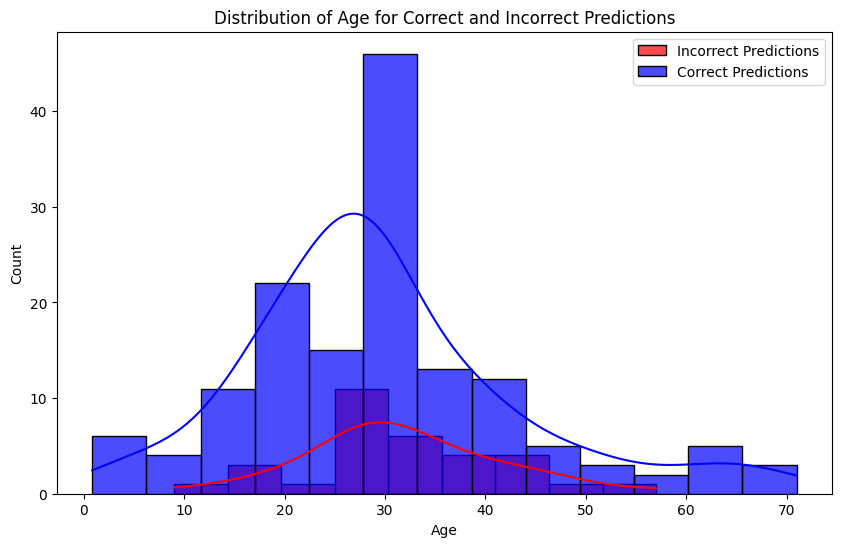

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizing the 'Age' distribution for correct and incorrect predictions
plt.figure(figsize=(10, 6))
sns.histplot(data=incorrect_predictions, x='Age', label='Incorrect Predictions', color='red', alpha=0.7, kde=True)
sns.histplot(data=X_val[y_val == predictions_val_gb_tuned], x='Age', label='Correct Predictions', color='blue', alpha=0.7, kde=True)
plt.title('Distribution of Age for Correct and Incorrect Predictions')
plt.legend()
plt.show()

In [58]:
# Example: Fine-tuning the Gradient Boosting model
tuned_gb_model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, max_depth=3, random_state=42)
tuned_gb_model.fit(X_train_scaled, y_train)
predictions_val_tuned_gb = tuned_gb_model.predict(X_val_scaled)
accuracy_val_tuned_gb = accuracy_score(y_val, predictions_val_tuned_gb)
print(f'Accuracy on the validation set after tuning: {accuracy_val_tuned_gb}')

Accuracy on the validation set after tuning: 0.8212290502793296


In [59]:
# Make predictions on the test set
predictions_fgb_test = tuned_gb_model.predict(X_test_scaled)

# Create a submission DataFrame
submission_fgb_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': predictions_fgb_test})

# Save the submission to a CSV file
submission_fgb_df.to_csv('submission_fgb.csv', index=False)